# Trajectory replay

## Initial setup

In [38]:
import sys
sys.path.insert(0, "../python/")
from memory.ReplayMemory import ReplayMemory
import numpy as np
import random
import copy

## Numpy indexing

### Batch slicing

In [19]:
idx = np.random.randint(0, 100, 7)
print("idx:", idx)

x, y = np.meshgrid(idx, np.arange(5))
slices = np.transpose(x + y).flatten()
print("Slices:\n", slices)
slices %= 100
print("Corrected slices:\n", slices)

s1_0 = np.random.rand(100, 12, 84, 84) # mimics memory with capacity 100
s1_1 = np.random.rand(2)
s1 = [s1_0, s1_1]
print("Original:")
print("s1[0].shape:", s1[0].shape)
print("s1[0][slices][0, ...]:")
print(s1[0][slices][0, 0, :3, :3])
print("s1[0][slices][5, ...]:")
print(s1[0][slices][5, 0, :3, :3])

rs = np.reshape(s1[0][slices], [7, 5, 12, 84, 84]) # [num of traj, traj len, state_shape...]
print("Reshape:")
print("s1[0][slices].shape:", rs.shape)
print("s1[0][slices][0][...]:")
print(rs[0, 0, 0, :3, :3])
print("s1[0][slices][1][...]:")
print(rs[1, 0, 0, :3, :3])

idx: [58  8 24 44 72 70 19]
Slices:
 [58 59 60 61 62  8  9 10 11 12 24 25 26 27 28 44 45 46 47 48 72 73 74 75 76
 70 71 72 73 74 19 20 21 22 23]
Corrected slices:
 [58 59 60 61 62  8  9 10 11 12 24 25 26 27 28 44 45 46 47 48 72 73 74 75 76
 70 71 72 73 74 19 20 21 22 23]
Original:
s1[0].shape: (100, 12, 84, 84)
s1[0][slices][0, ...]:
[[ 0.53546728  0.34858874  0.99254931]
 [ 0.98171926  0.22050952  0.32387461]
 [ 0.50426754  0.38082718  0.53164911]]
s1[0][slices][5, ...]:
[[ 0.90396477  0.21205504  0.47445172]
 [ 0.63509333  0.78279289  0.96300232]
 [ 0.17780579  0.22307001  0.1404238 ]]
Reshape:
s1[0][slices].shape: (7, 5, 12, 84, 84)
s1[0][slices][0][...]:
[[ 0.53546728  0.34858874  0.99254931]
 [ 0.98171926  0.22050952  0.32387461]
 [ 0.50426754  0.38082718  0.53164911]]
s1[0][slices][1][...]:
[[ 0.90396477  0.21205504  0.47445172]
 [ 0.63509333  0.78279289  0.96300232]
 [ 0.17780579  0.22307001  0.1404238 ]]


### Reverse order
Applicable for class without reshaping

In [57]:
a = np.random.rand(30)
print("a:")
print(a)
print("a[[lists]]:")
print(a[[4, 9, 14, 19, 24, 29]])
print("a[fancy indexing]:")
print(a[4::5])
print("Reverse order:")
for i in range(5)[::-1]: 
    print(a[i::5])

a:
[ 0.08736947  0.26904687  0.18850901  0.15742123  0.14138586  0.10484942
  0.29992704  0.22221412  0.57461042  0.80538772  0.00261921  0.22227756
  0.20479822  0.9082098   0.57885134  0.35208548  0.84299166  0.9774215
  0.64349928  0.30795383  0.56341805  0.89320403  0.51121639  0.31188183
  0.72205378  0.2704125   0.41581256  0.55601417  0.59611474  0.86199004]
a[[lists]]:
[ 0.14138586  0.80538772  0.57885134  0.30795383  0.72205378  0.86199004]
a[fancy indexing]:
[ 0.14138586  0.80538772  0.57885134  0.30795383  0.72205378  0.86199004]
Reverse order:
[ 0.14138586  0.80538772  0.57885134  0.30795383  0.72205378  0.86199004]
[ 0.15742123  0.57461042  0.9082098   0.64349928  0.31188183  0.59611474]
[ 0.18850901  0.22221412  0.20479822  0.9774215   0.51121639  0.55601417]
[ 0.26904687  0.29992704  0.22227756  0.84299166  0.89320403  0.41581256]
[ 0.08736947  0.10484942  0.00261921  0.35208548  0.56341805  0.2704125 ]


### Copying weights

In [47]:
w = np.transpose(np.tile(np.arange(4), [5, 1])).flatten()
print(w)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [48]:
w = np.transpose(np.tile(np.arange(4), [1, 1])).flatten()
print(w)

[0 1 2 3]


### Linear growth/decay

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def update_trajectory_length(epoch, total_epochs):
    frac_train = epoch / total_epochs
    if frac_train < tr_len_const:
        tr_len = tr_len_start
    elif frac_train < tr_len_const + tr_len_decay:
        tr_len = ((tr_len_stop - tr_len_start)
                       * (frac_train - tr_len_const) // tr_len_decay
                       + tr_len_start)
    else:
        tr_len = tr_len_stop
    return tr_len

tr_len_start = 1
tr_len_stop = 20
tr_len_const = 0.3
tr_len_decay = 0.7
e_total = 100

stats = []
for e in range(e_total):
    stats.append(update_trajectory_length(e, e_total))

In [3]:
def update_trajectory_length(epoch, total_epochs):
    frac_train = epoch / total_epochs
    if frac_train < tr_len_const:
        tr_len = tr_len_start
    elif frac_train < tr_len_const + tr_len_decay:
        tr_len = ((tr_len_stop - tr_len_start)
                  * (frac_train - tr_len_const) 
                  / tr_len_decay
                  + tr_len_start)
    else:
        tr_len = tr_len_stop
    return tr_len

tr_len_start = 1
tr_len_stop = 20
tr_len_const = 0.3
tr_len_decay = 0.7
e_total = 100

stats_ = []
for e in range(e_total):
    stats_.append(update_trajectory_length(e, e_total))

In [4]:
def update_trajectory_length(epoch, total_epochs):
    frac_train = epoch / total_epochs
    if frac_train < tr_len_const:
        tr_len = tr_len_start
    elif frac_train < tr_len_const + tr_len_decay:
        tr_len = ((tr_len_stop - tr_len_start)
                  * (frac_train - tr_len_const) 
                  / tr_len_decay
                  + tr_len_start)
    else:
        tr_len = tr_len_stop
    return int(round(tr_len))

tr_len_start = 1
tr_len_stop = 20
tr_len_const = 0.3
tr_len_decay = 0.7
e_total = 100

test_stats = []
for e in range(e_total):
    test_stats.append(update_trajectory_length(e, e_total))

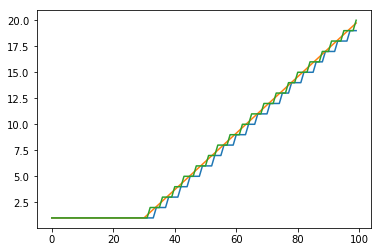

In [5]:
a = plt.plot(stats)
b = plt.plot(stats_)
c = plt.plot(test_stats)

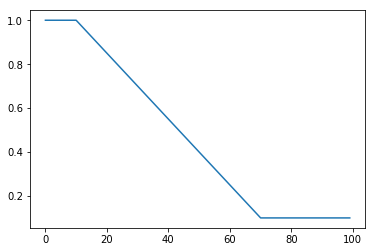

In [7]:
def get_exploration_rate(epoch, epoch_tot):
    epsilon_const_epochs = epsilon_const_rate * epoch_tot
    epsilon_decay_epochs = epsilon_decay_rate * epoch_tot
    if epoch < epsilon_const_epochs:
        return epsilon_start
    elif epoch < epsilon_const_epochs + epsilon_decay_epochs:
        # Linear decay
        return (epsilon_start
                + (epsilon_start - epsilon_end) / epsilon_decay_epochs 
                * (epsilon_const_epochs - epoch))
    else:
        return epsilon_end

epsilon_start = 1
epsilon_end = 0.1
epsilon_const_rate = 0.1
epsilon_decay_rate = 0.6
e_total = 100

test_stats = []
for e in range(e_total):
    test_stats.append(get_exploration_rate(e, e_total))

c = plt.plot(test_stats)

## Class definition

### Reshaping into [# of trajectories, trajectory length, ...]
I like the way this is organized and that the Replay Memory class is doing some of the dirty work. However, this is incompatible with other forms of replay memory, in which the shape is [batch_size, ...].

In [61]:
class TrajectoryReplayMemory(ReplayMemory):
    def __init__(self, capacity, state_shape, num_game_var, input_overlap=0, 
                 trajectory_length=5):
        # Initialize base replay memory
        ReplayMemory.__init__(self, capacity, state_shape, num_game_var, input_overlap)

        # Initialize trajectory parameters
        self.tr_len = trajectory_length
        
    def get_sample(self, sample_size):
        # Get random minibatch of indices
        idx = np.random.randint(0, self.size, sample_size)
        x, y = np.meshgrid(idx, np.arange(self.tr_len))
        idx = np.transpose(x + y).flatten() # [i, i+1, ..., i+n, j, j+1, ..., j+n, k...]
        idx %= self.capacity # wrap end cases
        t = self.tr_len
        # TODO: find isterminal in sequences and cut short
        
        # s = [screen[trajectory id, trajectory step, state_shape...], gv[traj id, traj step, num_gv]]
        
        # Make list of states
        s1_sample, s2_sample = [], []

        # Get screen component
        s1_slice = self.s1[0][idx]
        if self.overlap > 0:
            # Stack overlapping frames from s1 to stored frames of s2 to
            # recreate full s2 state
            s2_slice = np.concatenate((self.s1[0][[idx] + [slice(None)] * self.chdim 
                                             + [slice(None, self.overlap)]], 
                                             self.s2[0][idx]), 
                                            axis=self.chdim+1)
        else:
            s2_slice = self.s2[0][idx]
        s1_sample.append(np.reshape(s1_slice, [sample_size, t] + self.state_shape))
        s2_sample.append(np.reshape(s2_slice, [sample_size, t] + self.state_shape))

        # Get game variable component
        s1_sample.append(np.reshape(self.s1[1][idx], [sample_size, t] + [self.num_game_var]))
        s2_sample.append(np.reshape(self.s2[1][idx], [sample_size, t] + [self.num_game_var]))

        # Get other transition parameters
        a_sample = np.reshape(self.a[idx], [sample_size, t])
        isterminal_sample = np.reshape(self.isterminal[idx], [sample_size, t])
        r_sample = np.reshape(self.r[idx], [sample_size, t])

        # Return importance sampling weights of one (stochastic distribution)
        w = np.ones([sample_size, t])

        return s1_sample, a_sample, s2_sample, isterminal_sample, r_sample, w, idx

In [62]:
capacity = 100
state_shape = [12, 84, 84]
num_game_var = 2
input_overlap = 3
trajectory_length = 10
memory = TrajectoryReplayMemory(capacity=capacity,
                                state_shape=state_shape,
                                num_game_var=num_game_var,
                                input_overlap=input_overlap,
                                trajectory_length=trajectory_length)
terminal_states = random.sample(range(capacity), 7)
s1, s2 = [], []
s2.append(np.random.rand(state_shape[0], state_shape[1], state_shape[2]))
s2.append([random.random()] * num_game_var)
for i in range(capacity):
    s1 = [s2[0], s2[1]]
    s2[0] = np.delete(s2[0], np.s_[0:input_overlap], axis=0)
    s2[0] = np.append(s2[0], np.random.rand(input_overlap, state_shape[1], state_shape[2]), axis=0)
    s2[1] = [random.random()] * num_game_var
    a = random.sample(range(4), 1)[0]
    r = random.random()
    isterminal = i in terminal_states
    memory.add_transition(s1, a, s2, isterminal, r)  

In [63]:
s1, a, s2, isterminal, r, w, idx = memory.get_sample(7)
print("idx:", idx)
print("s1[0].shape:", s1[0].shape)
print("s1[1].shape:", s1[1].shape)
print("a.shape:", a.shape)
print("s2[0].shape:", s2[0].shape)
print("s2[1].shape:", s2[1].shape)
print("isterminal.shape:", isterminal.shape)
print("r.shape:", r.shape)
print("w.shape:", w.shape)

idx: [ 1  2  3  4  5  6  7  8  9 10 64 65 66 67 68 69 70 71 72 73 95 96 97 98 99
  0  1  2  3  4 77 78 79 80 81 82 83 84 85 86 26 27 28 29 30 31 32 33 34 35
 87 88 89 90 91 92 93 94 95 96  4  5  6  7  8  9 10 11 12 13]
s1[0].shape: (7, 10, 12, 84, 84)
s1[1].shape: (7, 10, 2)
a.shape: (7, 10)
s2[0].shape: (7, 10, 12, 84, 84)
s2[1].shape: (7, 10, 2)
isterminal.shape: (7, 10)
r.shape: (7, 10)
w.shape: (7, 10)


### No reshaping, [batch_size, ...]
This returns experiences in the form [batch_size, ...], where batch_size = (# of trajectories, i.e. sample_size) * (trajectory length). This form is compatible with current Replay Memory classes.

In [14]:
class TrajectoryReplayMemory(ReplayMemory):
    def __init__(self, capacity, state_shape, num_game_var, input_overlap=0, 
                 trajectory_length=5):
        # Initialize base replay memory
        ReplayMemory.__init__(self, capacity, state_shape, num_game_var, input_overlap)

        # Initialize trajectory parameters
        self.tr_len = trajectory_length
        
    def get_sample(self, sample_size):
        # Get random minibatch of indices
        idx = np.random.randint(0, self.size, sample_size)
        x, y = np.meshgrid(idx, np.arange(self.tr_len))
        idx = np.transpose(x + y).flatten() # [i, i+1, ..., i+n, j, j+1, ..., j+n, k...]
        idx %= self.capacity # wrap end cases
        t = self.tr_len
        # TODO: find isterminal in sequences and cut short
          
        # Make list of states
        s1_sample, s2_sample = [], []

        # Get screen component
        s1_slice = self.s1[0][idx]
        if self.overlap > 0:
            # Stack overlapping frames from s1 to stored frames of s2 to
            # recreate full s2 state
            s2_slice = np.concatenate((self.s1[0][[idx] + [slice(None)] * self.chdim 
                                             + [slice(None, self.overlap)]], 
                                             self.s2[0][idx]), 
                                            axis=self.chdim+1)
        else:
            s2_slice = self.s2[0][idx]
        s1_sample.append(s1_slice)
        s2_sample.append(s2_slice)

        # Get game variable component
        s1_sample.append(self.s1[1][idx])
        s2_sample.append(self.s2[1][idx])

        # Get other transition parameters
        a_sample = self.a[idx]
        isterminal_sample = self.isterminal[idx]
        r_sample = self.r[idx]

        # Return importance sampling weights of one (stochastic distribution)
        w = np.ones([sample_size * t])

        return s1_sample, a_sample, s2_sample, isterminal_sample, r_sample, w, idx

In [15]:
capacity = 100
state_shape = [12, 84, 84]
num_game_var = 2
input_overlap = 3
trajectory_length = 10
memory = TrajectoryReplayMemory(capacity=capacity,
                                state_shape=state_shape,
                                num_game_var=num_game_var,
                                input_overlap=input_overlap,
                                trajectory_length=trajectory_length)
terminal_states = random.sample(range(capacity), 7)
s1, s2 = [], []
s2.append(np.random.rand(state_shape[0], state_shape[1], state_shape[2]))
s2.append([random.random()] * num_game_var)
for i in range(capacity):
    s1 = [s2[0], s2[1]]
    s2[0] = np.delete(s2[0], np.s_[0:input_overlap], axis=0)
    s2[0] = np.append(s2[0], np.random.rand(input_overlap, state_shape[1], state_shape[2]), axis=0)
    s2[1] = [random.random()] * num_game_var
    a = random.sample(range(4), 1)[0]
    r = random.random()
    isterminal = i in terminal_states
    memory.add_transition(s1, a, s2, isterminal, r)  

In [16]:
s1, a, s2, isterminal, r, w, idx = memory.get_sample(7)
print("idx:", idx)
print("s1[0].shape:", s1[0].shape)
print("s1[1].shape:", s1[1].shape)
print("a.shape:", a.shape)
print("s2[0].shape:", s2[0].shape)
print("s2[1].shape:", s2[1].shape)
print("isterminal.shape:", isterminal.shape)
print("r.shape:", r.shape)
print("w.shape:", w.shape)

idx: [46 47 48 49 50 51 52 53 54 55 78 79 80 81 82 83 84 85 86 87 42 43 44 45 46
 47 48 49 50 51 77 78 79 80 81 82 83 84 85 86 84 85 86 87 88 89 90 91 92 93
 90 91 92 93 94 95 96 97 98 99 24 25 26 27 28 29 30 31 32 33]
s1[0].shape: (70, 12, 84, 84)
s1[1].shape: (70, 2)
a.shape: (70,)
s2[0].shape: (70, 12, 84, 84)
s2[1].shape: (70, 2)
isterminal.shape: (70,)
r.shape: (70,)
w.shape: (70,)


In [24]:
sample = [s1[0][6::10], s1[1][6::10]]
print(len(sample), sample[0].shape, sample[1].shape)

2 (7, 12, 84, 84) (7, 2)


## Agent testing

In [39]:
# If using one or multiple GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [40]:
from helper import create_agent
import tensorflow as tf
from vizdoom import *
%load_ext autoreload
%autoreload 2

In [41]:
# Initializes DoomGame from config file
def initialize_vizdoom(config_file):
    print("Initializing doom... ", end=""), sys.stdout.flush()
    game = DoomGame()
    game.load_config(config_file)
    game.set_window_visible(True)
    game.init()
    print("Done.")
    return game

### Standard experience replay

In [55]:
tf.reset_default_graph()
agent_file_path = "./trajectory_experience_replay/standard.json"
config_file_path = "../config/open_field.cfg"
results_dir = "./trajectory_experience_replay/results"

game = initialize_vizdoom(config_file_path)
agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=None,
                     action_set=None,
                     output_directory=results_dir,
                     train_mode=True)

agent.initialize_new_episode()
for i in range(500): # memory capacity set to 100
    agent.perform_learning_step(1, 100)
    if game.is_episode_finished():
        agent.initialize_new_episode()
game.close()
print("Done.")

Initializing doom... Done.

Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)
[GameVariable.HEALTH] --> Tensor("main_network/health:0", shape=(?, 1), dtype=float32)
[GameVariable.VELOCITY_X, GameVariable.VELOCITY_Y] --> Tensor("main_network/velocity:0", shape=(?, 2), dtype=float32)
Done.


### Prioritized experience replay

In [61]:
tf.reset_default_graph()
agent_file_path = "./trajectory_experience_replay/prioritized.json"
config_file_path = "../config/open_field.cfg"
results_dir = "./trajectory_experience_replay/results"

game = initialize_vizdoom(config_file_path)
agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=None,
                     action_set=None,
                     output_directory=results_dir,
                     train_mode=True)

agent.initialize_new_episode()
for i in range(250): # memory capacity set to 100
    agent.perform_learning_step(1, 100)
    if game.is_episode_finished():
        agent.initialize_new_episode()
game.close()
print("Done.")

Initializing doom... Done.

Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)
[GameVariable.HEALTH] --> Tensor("main_network/health:0", shape=(?, 1), dtype=float32)
[GameVariable.VELOCITY_X, GameVariable.VELOCITY_Y] --> Tensor("main_network/velocity:0", shape=(?, 2), dtype=float32)
Done.


Sampling...Done.
Calculating probs...Done.
Plotting...


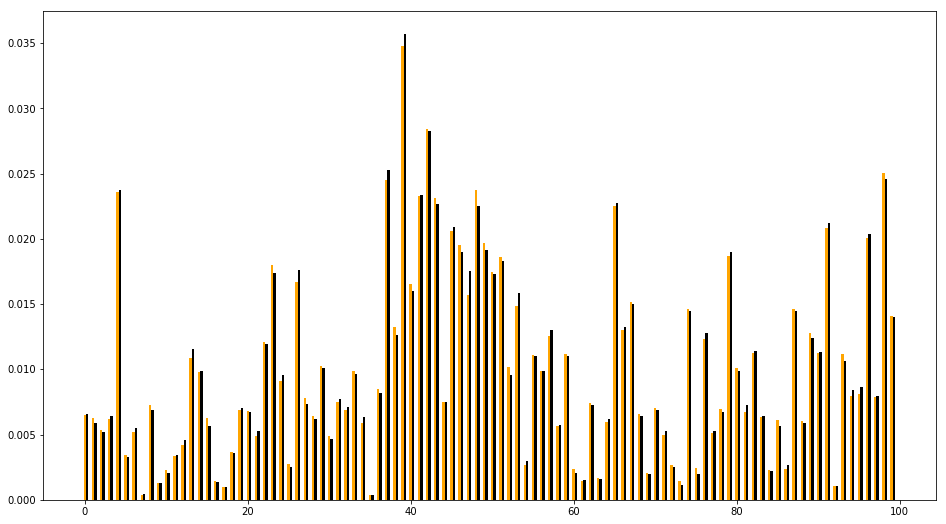

In [64]:
import random
import matplotlib.pyplot as plt

# Get samples
tr_len = agent.memory.tr_len
batch_size = 5
num_batches = 10000
t = []
print("Sampling...", end=""), sys.stdout.flush()
for i in range(num_batches):
    s1, a, s2, isterminal, r, w, t_i = agent.memory.get_sample(batch_size)
    t.append(t_i[tr_len-1::tr_len])
print("Done."), sys.stdout.flush()

t = np.asarray(t)

# Count how many times each
heap = agent.memory.heap
start_pos = agent.memory.start_pos
capacity = agent.memory.capacity
sample_size = 100
p_tot = heap[1]
calc_prob = np.zeros(sample_size)
actual_prob = np.zeros(sample_size)
print("Calculating probs...", end=""), sys.stdout.flush()
for j, i in enumerate(range(capacity)):
    p = heap[start_pos + i]
    calc_prob[j] = p / p_tot
    actual_prob[j] = np.sum(np.count_nonzero(t == i)) / t.size
    #print("Transition %d: calculated prob=%.3f, actual prob=%.3f" % (i, calc_prob, actual_prob))
print("Done."), sys.stdout.flush()

print("Plotting..."), sys.stdout.flush()
fig, ax = plt.subplots()
idx = np.arange(sample_size)
width = 0.3
ax.bar(idx, calc_prob, width, color="orange")
ax.bar(idx + width, actual_prob, width, color="black")
fig.set_size_inches(16, 9)
plt.show()

### Backwards update function

In [42]:
tf.reset_default_graph()
agent_file_path = "./trajectory_experience_replay/standard.json"
config_file_path = "../config/open_field.cfg"
results_dir = "./trajectory_experience_replay/results"

game = initialize_vizdoom(config_file_path)
agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=None,
                     action_set=None,
                     output_directory=results_dir,
                     train_mode=True)

agent.initialize_new_episode()
for i in range(500): # memory capacity set to 100
    agent.perform_learning_step(1, 100)
    if game.is_episode_finished():
        agent.initialize_new_episode()
game.close()
print("Done.")

Initializing doom... Done.
Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)


../python/agent/Agent.py:170: UserWarning: The following game variables were not used: 
  warnings.warn(msg)


Done.


In [43]:
idx = np.random.randint(0, agent.memory.size, 10)
print(idx)
idx = agent.memory._get_valid_idx_trajectories(idx, 
                                               idx_start=None, 
                                               idx_end=None)
print(idx)

[65  0 82  2 29 30 52 21  0 15]
[65 64 63 62 61 60 59 58 57 56  0 -1 -2 -3 -4 -5 -6 -7 -8 -9 82 81 80 79 78
 77 76 75 74 73  2  1  0 -1 -2 -3 -4 -5 -6 -7 29 28 27 26 25 24 23 22 21 20
 30 29 28 27 26 25 24 23 22 21 52 51 50 49 48 47 46 45 44 43 21 20 19 18 17
 16 15 14 13 12  0 -1 -2 -3 -4 -5 -6 -7 -8 -9 15 14 13 12 11 10  9  8  7  6]


**3/13/18**: My fears confirmed. I had been assuming the order, which defaults to backwards update, was still chronological `([i-n, ..., i, j-n, ..., j, ...])`. However, it is in reverse order `([i, .., i-n, j, ..., j-n, ...])`, which matters both for backward trajectory updates in DQN and especially for temporal updates in DRQN.

Let's modify this line
```python
idx = np.transpose(x - y).flatten()
```

to be:
```python
idx = np.transpose(x + y).flatten()
idx -= (self.tr_len - 1) * self.n_step
```

In [52]:
tf.reset_default_graph()
agent_file_path = "./trajectory_experience_replay/standard.json"
config_file_path = "../config/open_field.cfg"
results_dir = "./trajectory_experience_replay/results"

game = initialize_vizdoom(config_file_path)
agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=None,
                     action_set=None,
                     output_directory=results_dir,
                     train_mode=True)

agent.initialize_new_episode()
for i in range(500): # memory capacity set to 100
    agent.perform_learning_step(1, 100)
    if game.is_episode_finished():
        agent.initialize_new_episode()
game.close()
print("Done.")

Initializing doom... Done.
Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)


../python/agent/Agent.py:170: UserWarning: The following game variables were not used: 
  warnings.warn(msg)


Done.


In [53]:
idx = np.random.randint(0, agent.memory.size, 10)
print(idx)
idx = agent.memory._get_valid_idx_trajectories(idx, 
                                               idx_start=None, 
                                               idx_end=None)
print(idx)

[39 11 55 56 79 37 27 31 28  3]
[30 31 32 33 34 35 36 37 38 39  2  3  4  5  6  7  8  9 10 11 46 47 48 49 50
 51 52 53 54 55 47 48 49 50 51 52 53 54 55 56 70 71 72 73 74 75 76 77 78 79
 28 29 30 31 32 33 34 35 36 37 18 19 20 21 22 23 24 25 26 27 22 23 24 25 26
 27 28 29 30 31 19 20 21 22 23 24 25 26 27 28 -6 -5 -4 -3 -2 -1  0  1  2  3]


Now the trajectories are ordered correctly.

## Constraining trajectories within episodes

In [2]:
import numpy as np

In [104]:
size = 50
sample_size = 6
tr_len = 4
n_step = 3
is_terminal = np.zeros(size)
is_terminal[np.random.randint(0, size, 5)] = 1
print(is_terminal)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [105]:
# Get random minibatch of indices
idx = np.random.randint(0, size, sample_size)

# Create trajectories
x, y = np.meshgrid(idx, np.arange(tr_len) * n_step) # non-overlapping n-step sequences
idx = np.transpose(x + y).flatten() # [i-n, i-n+1, ..., i, j-n, j-n+1, ..., j, ...]
idx -= (tr_len - 1) * n_step

# Constrain to within episodes
print(idx)
idx_terminal = np.sum((idx == np.argwhere(is_terminal)), axis=0) # forward indexing i
print(idx_terminal)
idx_terminal += np.sum(idx == (np.argwhere(is_terminal) - size), axis=0) # reverse indexing -(size-i)
print(idx_terminal)

[-7 -4 -1  2  6  9 12 15  8 11 14 17 -1  2  5  8 -5 -2  1  4 27 30 33 36]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [110]:
a, b = np.meshgrid(np.argwhere(is_terminal), np.arange((tr_len - 1) * n_step) + 1)
print(a)
print(b)
invalid_end_idx = np.unique(np.transpose(a+b).flatten())
print(invalid_end_idx)
invalid_end_idx %= size
print(invalid_end_idx)
valid_end_idx = np.ones(size)
valid_end_idx[invalid_end_idx] = 0
print(valid_end_idx)
valid_end_idx = np.argwhere(valid_end_idx)
print(valid_end_idx.flatten())

[[13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]]
[[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]
 [6 6 6 6 6]
 [7 7 7 7 7]
 [8 8 8 8 8]
 [9 9 9 9 9]]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 49
 50 51 52 53 54 55 56 57]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 49
  0  1  2  3  4  5  6  7]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
[ 8  9 10 11 12 13 38 39 40 41 42 43 44 45 46 47 48]


In [111]:
a, b = np.meshgrid(np.argwhere(is_terminal), np.arange((tr_len - 1) * n_step) + 1)
print(a)
print(b)
invalid_end_idx = np.unique(np.transpose(a+b).flatten())
invalid_end_idx -= (tr_len - 1) * n_step
print(invalid_end_idx)
invalid_end_idx %= size
print(invalid_end_idx)
valid_end_idx = np.ones(size)
valid_end_idx[invalid_end_idx] = 0
print(valid_end_idx)
valid_end_idx = np.argwhere(valid_end_idx)
print(valid_end_idx.flatten())

[[13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]
 [13 14 20 28 48]]
[[1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]
 [6 6 6 6 6]
 [7 7 7 7 7]
 [8 8 8 8 8]
 [9 9 9 9 9]]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 40
 41 42 43 44 45 46 47 48]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 40
 41 42 43 44 45 46 47 48]
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0  1  2  3  4 29 30 31 32 33 34 35 36 37 38 39 49]


In [126]:
def _get_valid_idx(idx, valid_idx, side='right'):
        # Check intent since 'right' assumed below
        if side not in ['left', 'right']:
            raise ValueError("Undefined value \"" + side + "\" for arg 'side'.")
        
        # Round to nearest right-sided valid idx doing left-sided search
        valid_idx = np.sort(valid_idx) # sort if not already sorted
        new_idx_ = np.searchsorted(valid_idx, idx, side='left') # right-sided round
        new_idx_ %= len(valid_idx) # wrap end case
        
        # Round to nearest left-sided valid idx if specified
        if side == 'left':
            new_idx = valid_idx[new_idx_]
            new_idx_ = new_idx_ - (new_idx != idx) # left shift if not equal
        
        return valid_idx[new_idx_]

def _get_valid_idx_trajectories(idx, idx_start=None, idx_end=None):
        # Get trajectories constrained within episodes (do not cross terminal states)
        a, b = np.meshgrid(np.argwhere(is_terminal), np.arange((tr_len - 1) * n_step) + 1)
        invalid_idx = np.unique(np.transpose(a+b).flatten())
        invalid_idx %= size
        if idx_start is not None:
            invalid_idx -= (tr_len - 1) * n_step
        valid_idx = np.ones(size)
        valid_idx[invalid_idx] = 0
        valid_idx = np.argwhere(valid_idx).flatten()

        # If shifted to valid start values, move forward in trajectory
        if idx_start is not None:
            idx_start = np.unique(np.concatenate(idx_start, valid_idx))
            idx = _get_valid_idx(idx, idx_start, side='left')
            x, y = np.meshgrid(idx, np.arange(tr_len) * n_step) # non-overlapping n-step sequences
            idx = np.transpose(x + y).flatten() # [i, i+1, ..., i+n, j, j+1, ..., j+n, k...]
            idx %= size # wrap end cases
        
        # Otherwise, move backward in trajectory
        else:
            if idx_end is not None:
                idx_end = np.unique(np.concatenate(idx_end, valid_idx))
            else:
                idx_end = valid_idx
            idx = _get_valid_idx(idx, idx_end, side='right')
            x, y = np.meshgrid(idx, np.arange(tr_len) * n_step) # non-overlapping n-step sequences
            idx = np.transpose(x + y).flatten() # [i, i+1, ..., i+n, j, j+1, ..., j+n, k...]
            idx -= (tr_len - 1) * n_step # [i-n, i-n+1, ..., i, j-n, j-n+1, ..., j, ...]
        
        return idx

In [128]:
idx = np.random.randint(0, size, sample_size)
print(idx)
print(is_terminal)
idx = _get_valid_idx_trajectories(idx)
print(idx)

[ 1  4 35 10 14 33]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[-1  2  5  8 -1  2  5  8 29 32 35 38  1  4  7 10 29 32 35 38 29 32 35 38]
